# Notebook to visualize SAE and bounding boxes related to a sample in PEDRo Dataset

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET
from matplotlib.patches import Rectangle
import PIL.Image as Image

## <span style="color:red">! Modify the path where the dataset is located !</span>

In [2]:
#dataset_folder = "./YOLOv8/datasets/PEDRo_CAMERA_READY"
dataset_folder = "./examples"

## <span style="color:red">! Select the folder and the number of the sample !</span>

In [3]:
group = "train"
frame_no = 2015

In [4]:
dataset_numpy_path = os.path.join(os.getcwd(), f'{dataset_folder}/numpy/{group}')
dataset_yolo_path = os.path.join(os.getcwd(), f'{dataset_folder}/yolo/{group}')
dataset_xml_path = os.path.join(os.getcwd(), f'{dataset_folder}/xml/{group}')

frame_name = "frame" + (str(frame_no)).zfill(7)

## <span style="color:red">! Select the camera resolution and the time interval to build the SAE !</span>

In [9]:
#Defining the camera resolution
img_w = 346
img_h = 260

#Defining the time interval to build the SAE
time_interval = 40e3

Retrieve the bounding boxes of the selected sample

In [10]:
#BBOX
# parse xml file
tree = ET.parse(os.path.join(dataset_xml_path, f"{frame_name}.xml")) 
root = tree.getroot() # get root object
width = int(root.find("size")[0].text)
height = int(root.find("size")[1].text)
channels = int(root.find("size")[2].text)
bbox_coordinates = []
for member in root.findall('object'):
    class_name = member[0].text # class name
        
    # bbox coordinates
    xmin = int(member[4][0].text)
    ymin = int(member[4][1].text)
    xmax = int(member[4][2].text)
    ymax = int(member[4][3].text)
    # store data in list
    bbox_coordinates.append([class_name, xmin, ymin, xmax, ymax])

Create the Surface of Active Events (SAE) from the numpy that contains the events belonging to the selected sample

In [11]:
#SAE
events = np.load(os.path.join(dataset_numpy_path, f"{frame_name}.npy"))
df_events = pd.DataFrame({'timestamp': events[:,0], 'x': events[:,1], 'y': events[:,2], 'polarity': events[:,3]})

timestamps_vector = df_events['timestamp'].to_numpy()

#Separating positive and negative events
df_events_neg = df_events[df_events['polarity'] == 0]
df_events_pos = df_events[df_events['polarity'] == 1]
                
#Keeping only the last events per (x,y) - good for sae only                                
df_events_neg_remaining = df_events_neg.sort_values(by='timestamp').drop_duplicates(subset=['x', 'y'], keep='last', inplace=False)
df_events_pos_remaining = df_events_pos.sort_values(by='timestamp').drop_duplicates(subset=['x', 'y'], keep='last', inplace=False)

#Creating an empty time surface with two channels (positive and negative)
sae = np.zeros((img_w, img_h, 2), dtype='float32')

#Selecting time_limit as the timestamp of the last event in the sample
time_limit = int(timestamps_vector[-1])
#Selecting t_init_0 as the difference between time_limit and the time interval (in this case is 40 ms)
t_init_0 = int(timestamps_vector[-1]-time_interval)

#Considering only the last event occurred in each pixel - This approach is suitable only for SAE
df_events_neg_remaining_subset = df_events_neg_remaining[df_events_neg_remaining['timestamp'].isin(range(t_init_0, time_limit))]
df_events_pos_remaining_subset = df_events_pos_remaining[df_events_pos_remaining['timestamp'].isin(range(t_init_0, time_limit))]

#Filling the negative surface - SAE
x_neg = df_events_neg_remaining_subset['x'].to_numpy()
y_neg = df_events_neg_remaining_subset['y'].to_numpy()
t_neg = df_events_neg_remaining_subset['timestamp'].to_numpy()
sae[x_neg, y_neg, 1] = (255*((t_neg-t_init_0)/time_interval)).astype(int)

#Filling the positive surface - SAE
x_pos = df_events_pos_remaining_subset['x'].to_numpy()
y_pos = df_events_pos_remaining_subset['y'].to_numpy()
t_pos = df_events_pos_remaining_subset['timestamp'].to_numpy()
print(t_pos-t_init_0
sae[x_pos, y_pos, 0] = (255*((t_pos-t_init_0)/time_interval)).astype(int)

im = Image.fromarray(0.5*sae[:,:,0].T + 0.5*sae[:,:,1].T).convert("L")

[    0     0     1 ... 39996 39997 39999]


Plot the SAE and the bounding boxes resulting from the selected sample

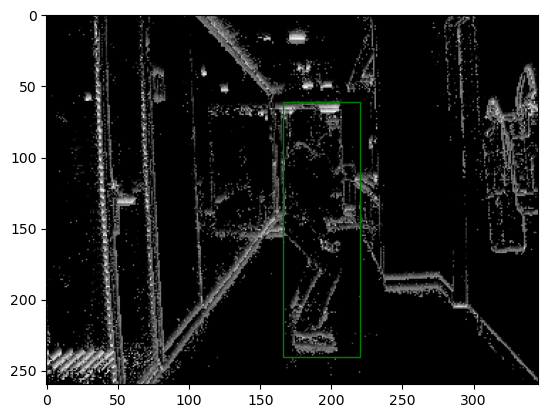

In [12]:
sae_plot = plt.imshow(im, cmap="gray")
ax = plt.gca()
for i in range(len(bbox_coordinates)):
    # Create a Rectangle patch
    xmin = bbox_coordinates[i][1]
    ymin = bbox_coordinates[i][2]
    width_lbl = bbox_coordinates[i][3] - xmin
    height_lbl = bbox_coordinates[i][4] - ymin
    rect = Rectangle((xmin, ymin), width_lbl, height_lbl ,linewidth=1,edgecolor='g',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
                           
plt.show()